## Micrograd with GPU
A autodiff engine inspired by Andrej Karpathy's tutorial (https://www.youtube.com/watch?v=VMj-3S1tku0&t=2105s)

### A simple class to store data values

In [1]:
import math

In [2]:
class Value:

    def __init__(self, data, _children=(), _op='', label=''):
        self.data = data
        self.grad = 0
        self._prev = set(_children)
        self._op = _op
        self.label = label

    def __repr__(self):
        return f"Value(label={self.label}, data={self.data})"

    def __add__(self, other):
        return Value(self.data + other.data, (self, other), '+')

    def __mul__(self, other):
        return Value(self.data * other.data, (self, other), '*')

    def activation(self, _type='tanh'):
        x = self.data
        if _type == 'tanh':
            t = (math.exp(2*x) - 1) / (math.exp(2*x) + 1)
            out = Value(t, (self, ), 'tanh')
            return out
            
        if _type == 'relu':
            t = max(0, x)
            out = Value(t, (self, ), 'relu')
            return out
        

In [3]:
a = Value(2, label='a')
b = Value(0.5, label='b')
c = Value(4, label='c')
d = a + b; d.label = 'd'
e = d * c; e.label = 'e'
f = Value(-2, label='f')
L = e * f; L.label='L'
print(f"a = {a}\nb = {b}\nc = {c}")
print(f"a + b = {d}")
print(f"(a + b) * c = {e}")
print(f"L = {L}")

a = Value(label=a, data=2)
b = Value(label=b, data=0.5)
c = Value(label=c, data=4)
a + b = Value(label=d, data=2.5)
(a + b) * c = Value(label=e, data=10.0)
L = Value(label=L, data=-20.0)


In [4]:
d._prev, d._op

({Value(label=a, data=2), Value(label=b, data=0.5)}, '+')

In [5]:
e._prev, e._op

({Value(label=c, data=4), Value(label=d, data=2.5)}, '*')

### Visualization

In [6]:
from graphviz import Digraph

def trace(root):
  # builds a set of all nodes and edges in a graph
  nodes, edges = set(), set()
  def build(v):
    if v not in nodes:
      nodes.add(v)
      for child in v._prev:
        edges.add((child, v))
        build(child)
  build(root)
  return nodes, edges

def draw_dot(root):
  dot = Digraph(format='svg', graph_attr={'rankdir': 'LR'}) # LR = left to right
  
  nodes, edges = trace(root)
  for n in nodes:
      uid = str(id(n))
      # for any value in the graph, create a rectangular ('record') node for it
      dot.node(name = uid, label = "{ %s | data %.4f | grad %.4f}" % (n.label, n.data, n.grad), shape='record')
      if n._op:
          # if this value is a result of some operation, create an op node for it
          dot.node(name = uid + n._op, label = n._op)
          # and connect this node to it
          dot.edge(uid + n._op, uid)

  for n1, n2 in edges:
      # connect n1 to the op node of n2
      dot.edge(str(id(n1)), str(id(n2))+n2._op)

  return dot

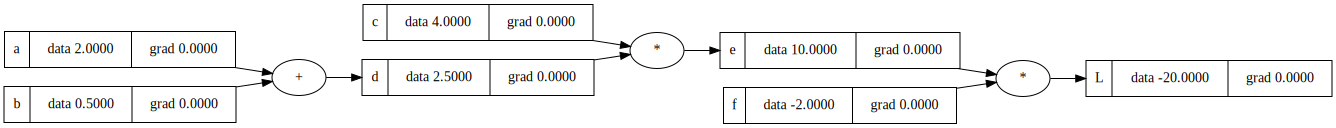

In [7]:
draw_dot(L)

### Calculate gradients manually (Backpropagation)
#### Example 1

In [8]:
def lol():
    h = 0.0001
    a = Value(2, label='a')
    b = Value(0.5, label='b')
    c = Value(4, label='c')
    d = a + b; d.label = 'd'
    e = d * c; e.label = 'e'
    f = Value(-2, label='f')
    L = e * f; L.label='L'
    L1 = L.data

    a = Value(2, label='a')
    b = Value(0.5+h, label='b')
    c = Value(4, label='c')
    d = a + b; d.label = 'd'
    e = d * c; e.label = 'e'
    f = Value(-2, label='f')
    L = e * f; L.label='L'
    L2 = L.data
    
    print((L2 - L1)/h)

In [9]:
lol()

-7.999999999981355


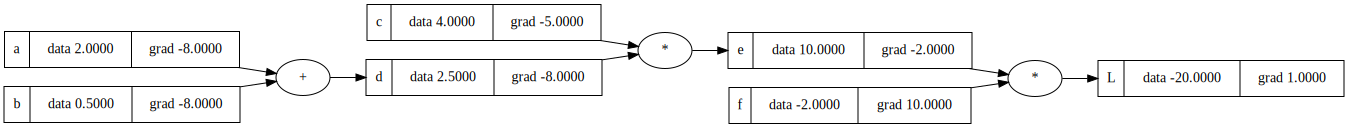

In [10]:
L.grad = 1
f.grad = e.data
e.grad = f.data
c.grad = e.grad * d.data
d.grad = e.grad * c.data
a.grad = d.grad
b.grad = d.grad
draw_dot(L)

#### Update data values to change the value of L

In [11]:
# Forward pass
a.data += 0.01*a.grad
b.data += 0.01*b.grad
c.data += 0.01*c.grad
f.data += 0.01*c.grad

d = a + b
e = d * c
L = e * f

print(L.data)

-18.94815


#### Example 2
##### NN with tanh activation

In [12]:
# Inputs
x1 = Value(-1.0, label='x1')
x2 = Value(2.0, label='x2')

In [13]:
# Weights
w1 = Value(0.5, label='w1')
w2 = Value(0.8, label='w2')

In [14]:
# Bias
b = Value(1.0, label='b')

In [15]:
# Forward pass
x1w1 = x1*w1; x1w1.label='x1*w1'
x2w2 = x2*w2; x2w2.label='x2*w2'
x1w1_x2w2 = x1w1 + x2w2; x1w1_x2w2.label='x1*w1 + x2*w2'
n = x1w1_x2w2 + b; n.label = 'n'
out = n.activation('tanh'); out.label='output'

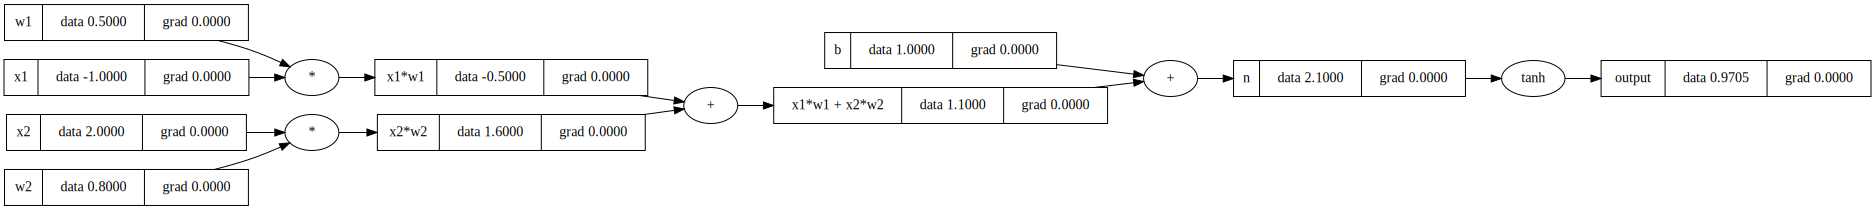

In [16]:
draw_dot(out)

In [17]:
out.grad = 1.0

In [18]:
# out = tanh(n)
# dout/dn = 1 - out**2
n.grad = 1 - out.data**2

In [19]:
b.grad = n.grad
x1w1_x2w2.grad = n.grad

x1w1.grad = x1w1_x2w2.grad
x2w2.grad = x1w1_x2w2.grad

x1.grad = x1w1.grad * w1.data
w1.grad = x1w1.grad * x1.data

x2.grad = x2w2.grad * w2.data
w2.grad = x2w2.grad * x2.data


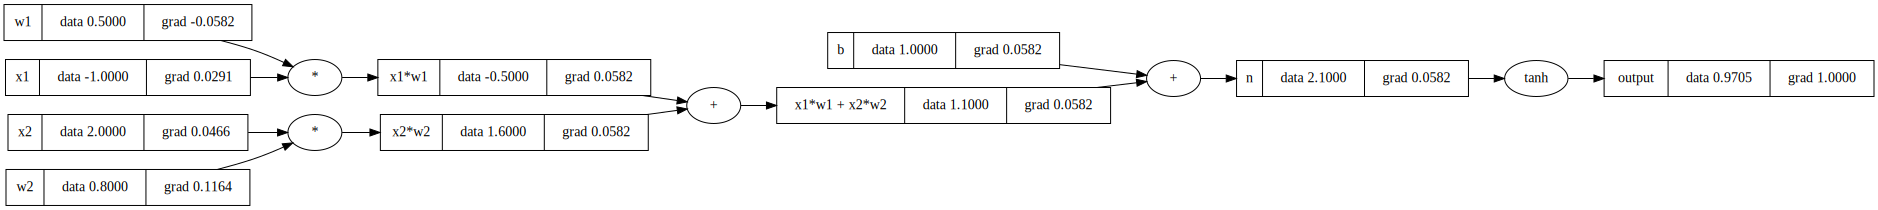

In [20]:
draw_dot(out)

##### NN with ReLU activation

In [21]:
# Inputs
x1 = Value(-1.0, label='x1')
x2 = Value(2.0, label='x2')

# Weights
w1 = Value(0.5, label='w1')
w2 = Value(0.8, label='w2')

# Bias
b = Value(1.0, label='b')

In [22]:
# Forward pass
x1w1 = x1*w1; x1w1.label='x1*w1'
x2w2 = x2*w2; x2w2.label='x2*w2'
x1w1_x2w2 = x1w1 + x2w2; x1w1_x2w2.label='x1*w1 + x2*w2'
n = x1w1_x2w2 + b; n.label = 'n'
out = n.activation('relu'); out.label='output'

In [23]:
out.grad = 1.0

# out = relu(n)
# dout/dn = 0 if out == 0, 1 if out > 0

if out.data == 0:
    n.grad = 0.0
elif out.data > 0:
    n.grad = 1.0

In [24]:
b.grad = n.grad
x1w1_x2w2.grad = n.grad

x1w1.grad = x1w1_x2w2.grad
x2w2.grad = x1w1_x2w2.grad

x1.grad = x1w1.grad * w1.data
w1.grad = x1w1.grad * x1.data

x2.grad = x2w2.grad * w2.data
w2.grad = x2w2.grad * x2.data

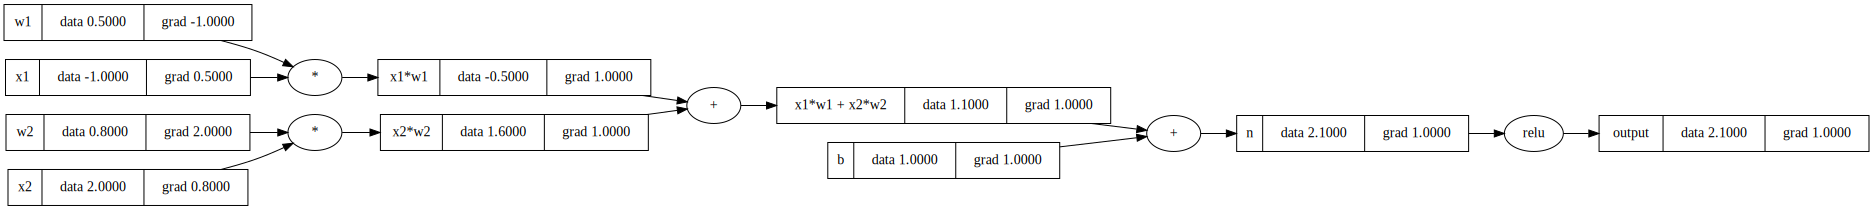

In [25]:
draw_dot(out)

### Backpropagation Implementation (Automated)

In [82]:
class Value:

    def __init__(self, data, _children=(), _op='', label=''):
        self.data = data
        self.grad = 0
        self._backward = lambda: None
        self._prev = set(_children)
        self._op = _op
        self.label = label

    def __repr__(self):
        return f"Value(label={self.label}, data={self.data})"

    def __add__(self, other):
        out = Value(self.data + other.data, (self, other), '+')
        def _backward():
            self.grad += 1 * out.grad
            other.grad += 1 * out.grad
        out._backward = _backward
        return out

    def __mul__(self, other):
        out = Value(self.data * other.data, (self, other), '*')
        def _backward():
            self.grad += other.data * out.grad
            other.grad += self.data * out.grad
        out._backward = _backward
        return out
        
    def activation(self, _type='tanh'):
        x = self.data
        if _type == 'tanh':
            t = (math.exp(2*x) - 1) / (math.exp(2*x) + 1)
            out = Value(t, (self, ), 'tanh')
            def _backward():
                self.grad = 1 - out.data**2
            out._backward = _backward
            return out
            
        if _type == 'relu':
            t = max(0, x)
            out = Value(t, (self, ), 'relu')
            def _backward():
                if out.data == 0:
                    self.grad = 0
                else:
                    self.grad = 1
            out._backward = _backward
            return out
    
    def backward(self):
        topo = []
        visited = set()
        self.grad = 1
        def build_topo(v):
            if v not in visited:
                visited.add(v)
                for child in v._prev:
                    build_topo(child)
                topo.append(v)
        build_topo(self)
        for n in reversed(topo):
            n._backward()

        return

In [83]:
# Inputs
x1 = Value(-1.0, label='x1')
x2 = Value(2.0, label='x2')

# Weights
w1 = Value(0.5, label='w1')
w2 = Value(0.8, label='w2')

# Bias
b = Value(1.0, label='b')

In [84]:
# Forward pass
x1w1 = x1*w1; x1w1.label='x1*w1'
x2w2 = x2*w2; x2w2.label='x2*w2'
x1w1_x2w2 = x1w1 + x2w2; x1w1_x2w2.label='x1*w1 + x2*w2'
n = x1w1_x2w2 + b; n.label = 'n'
out = n.activation('relu'); out.label='output'

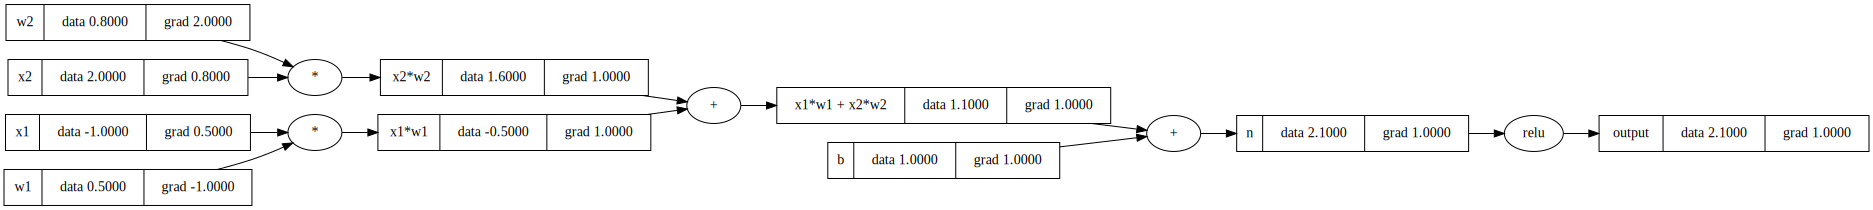

In [86]:
out.backward()
draw_dot(out)